Notebook to compile annual time series for a region using harmonized Landsat imagery
Gathers imagery from Landsat 5, 7, and 8 and returns a maximum-valued image for each year's
growing season.

In [4]:
try:
    import ee
except Exception as e:
    !pip install earthengine-api
    import ee
finally:
    import datetime, os, re
    import folium
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    %matplotlib inline

In [5]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AY0e-g79t95gO16G6LyfVweE80uhPRlhHa3NL8HHAFGSAyAuf8yvan98Et8



Successfully saved authorization token.


In [184]:
# Define functions for Landsat Imagery and Harmonize between 5, 7, and 8's sensors

## Account for differences in band numbering between sensors 
landsat_5_7_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa']
landsat_8_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'pixel_qa']
band_names = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa']
def rename_5_7_bands(image):
    return image.select(landsat_5_7_bands,band_names)
def rename_8_bands(image):
    return image.select(landsat_8_bands,band_names)

## Create function to harmonize bands based on coefficients 
def harmonize(image):
    return image.select(band_names[:-1])\
        .multiply(ee.Image.constant([0.8474, 0.8483, 0.9047, 0.8462, 0.8937, 0.9071])) \
        .add(ee.Image.constant([0.0003, 0.0088, 0.0061, 0.0412, 0.0254, 0.0172]).multiply(10000))\
        .round()\
        .float()\
        .addBands(image.select('pixel_qa'))

## Mask clouds and bad pixels
def cloud_mask(image):
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
            and qa.bitwiseAnd(cloudsBitMask).eq(0)
    return image.updateMask(mask)

## Calculate Normalized Difference Vegetation Index
def calc_ndvi(image):
    ''' Computes NDVI and returns as image'''
    ndvi = image.normalizedDifference(['NIR','RED']).rename('NDVI')
    return image.addBands(ndvi)

def calc_ndbi(image):
    ''' Computes NDBI and returns as image'''
    ndbi = image.normalizedDifference(['SWIR1','NIR']).rename('NDBI')
    return image.addBands(ndbi)

def prep_8(image):
    orig = image
    image = calc_ndbi(calc_ndvi(cloud_mask(rename_8_bands(image))))
    return ee.Image(image.copyProperties(orig, orig.propertyNames())).float()
  
def prep_5_7(image):
    orig = image
    image = calc_ndbi(calc_ndvi(harmonize(cloud_mask(rename_5_7_bands(image)))))
    return ee.Image(image.copyProperties(orig, orig.propertyNames()))

In [170]:
# Define geometry
agdam = ee.Geometry.Rectangle([46.78,39.8,47.5,40.35])

In [171]:
# Dates for filtering image collections
start_date = '1984-01-01'
end_date = '2020-12-31'

# Create an annual ImageCollection based on start date
## Dates formatted for iterative loops
# start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d')
# end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')

In [172]:
# Access imagery from GEE repository

## Gather imageCollections from each Landsat series.
## Filter each by the AOI, cloud cover, and path/row.
l5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_SR")\
              .filterBounds(agdam).map(prep_5_7)\
              .filterMetadata('CLOUD_COVER_LAND','less_than',30)\
              .filter(ee.Filter.eq('WRS_PATH', 168))\
              .filter(ee.Filter.eq('WRS_ROW', 32))
l7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_SR")\
              .filterBounds(agdam).map(prep_5_7)\
              .filterMetadata('CLOUD_COVER_LAND','less_than',30)\
              .filter(ee.Filter.eq('WRS_PATH', 168))\
              .filter(ee.Filter.eq('WRS_ROW', 32))\
              .filterDate("2001-01-01","2013-12-31")
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
              .filterBounds(agdam).map(prep_8)\
              .filterMetadata('CLOUD_COVER_LAND','less_than',30)\
              .filter(ee.Filter.eq('WRS_PATH', 168))\
              .filter(ee.Filter.eq('WRS_ROW', 32))
              
## Merge into single collection
landsat578 = l8.merge(l7).merge(l5).sort('system:time_start')

In [173]:
# Create annual maximum imagery for the growing season, filling gaps due to clouds
# or bad pixels by using the three-year rolling maximum.

annual_maximums = [] # Holding folder for annual composite max images

# Iterate through each year in the study period
for year in range(int(start_date[:4]),int(end_date[:4])+1): 

    # Gather maximum values of image in year, considering only dates
    # in the growing season (April - October)
    maximum_image = landsat578\
                      .filterDate('{}-01-01'.format(year),'{}-12-31'.format(year))\
                      .filter(ee.Filter.dayOfYear(90,305))\
                      .max()\
                      .reproject(landsat578.first().select(0).projection())
    
    # Retrieve three-year max image for the given year
    three_year_filler = landsat578\
                      .filterDate('{}-01-01'.format(year-1),'{}-12-31'.format(year+2))\
                      .filter(ee.Filter.dayOfYear(90,305))\
                      .max()\
                      .reproject(landsat578.first().select(0).projection())
                      
    
    # Add the image to the annual_maximums list, filling pixels in from the three-
    # year composite where needed to fill gaps.
    annual_maximums.append(ee.ImageCollection.fromImages([maximum_image,three_year_filler])\
                    .reduce(ee.Reducer.firstNonNull())\
                    .rename('BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa', 'NDVI', 'NDBI')\
                    .reproject(landsat578.first().select(0).projection())\
                    .set('system:index', str(year)))

In [ ]:
# Map images

map = folium.Map(location=[40,47],zoom_start=10)
vis_params = {'palette':['red', 'yellow', 'green']}
to_map = annual_maximums[25].select('NDVI').clip(agdam).getMapId(vis_params)
folium.raster_layers.TileLayer(
    tiles=to_map['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    control=True,
    name='Sums',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [186]:
l8.filter(ee.Filter.dayOfYear(190,250)).first().reduceRegion(reducer = ee.Reducer.minMax(),
                                geometry = agdam,
                                maxPixels = 1e9).getInfo()

{'BLUE_max': 12607,
 'BLUE_min': -1447,
 'GREEN_max': 13434,
 'GREEN_min': -196,
 'NDBI_max': 0.7519956599240487,
 'NDBI_min': -0.7060839760068551,
 'NDVI_max': 0.9370871343189683,
 'NDVI_min': -0.430062630480167,
 'NIR_max': 13190,
 'NIR_min': 273,
 'RED_max': 13403,
 'RED_min': -95,
 'SWIR1_max': 13844,
 'SWIR1_min': 167,
 'SWIR2_max': 14503,
 'SWIR2_min': 126,
 'pixel_qa_max': 904,
 'pixel_qa_min': 322}

Wall time: 28.9 s


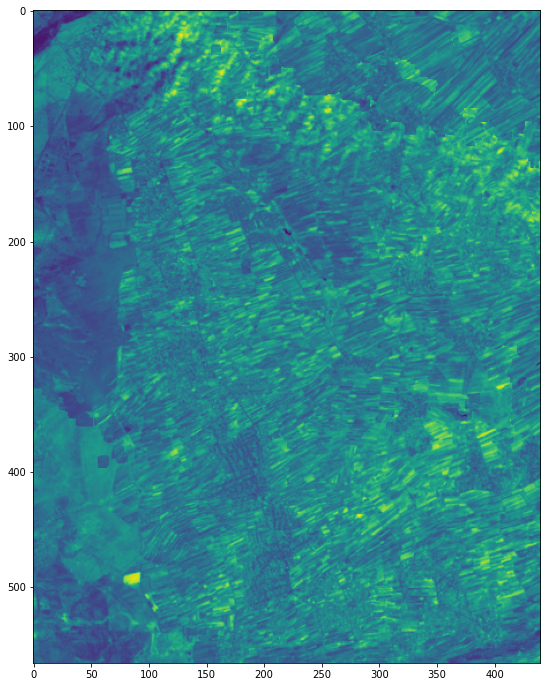

In [175]:
%%time
# NDVI Images
rect = ee.Geometry.Polygon(
        [[[47.0, 40.15],
          [47.0, 40.0],
          [47.15, 40.0],
          [47.15, 40.15]]])

# save_dir = r"G:\My Drive\GEE\GEE13MAR21_testing"
for i in range(25,26): # len(annual_maximums)
    in_image = ee.Image(annual_maximums[i])
    ee_array = in_image.sampleRectangle(region=rect,defaultValue=0)
    np_array_ndvi = np.array(ee_array.get('NIR').getInfo())
    plt.figure(figsize=(20,12))
    plt.imshow(np_array_ndvi)
#     img_year = in_image.get('system:index').getInfo()
#     out_image = Image.fromarray(np_array_ndvi)
#     out_image.save(os.path.join(save_dir,f"ndvi_image_{img_year}.tif"))

In [ ]:
import glob
tif_list = glob.glob(r"G:\My Drive\GEE\GEE13MAR21_testing\*.tif")
tif_list.sort()
ndvi_array_list = []
ndvi_date_list = []
for image in tif_list:
    img = Image.open(image)
    np_img = np.array(img)
    date = datetime.datetime.strptime(image.split("\\")[-1][11:21],'%Y-%m-%d')
    ndvi_date_list.append(date.timestamp())
    ndvi_array_list.append(np_img)
fig, axes = plt.subplots(2,4,subplot_kw={'xticks':(),'yticks':()},figsize=(20,12))
for image, ax in zip(list2,axes.ravel()):
    ax.imshow(image)

In [176]:
# Export annual max images
for i in range(0,len(annual_maximums)): 
    image = annual_maximums[i].select('BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDBI')
    task = ee.batch.Export.image.toDrive(image=image,
          description='agdam_max_'+str(image.get('system:index').getInfo()),
          folder= 'Agdam_Landsat_Max_Filled2',
          fileNamePrefix='agdam_max_'+str(image.get('system:index').getInfo()),
          region=agdam,
          scale=30,
          crs=landsat578.first().select(0).projection(),
          skipEmptyTiles=True)
    task.start()

KeyboardInterrupt: 

In [ ]:
def normalize(image):
    bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']
    std = image.reduceRegion(reducer = ee.Reducer.stdDev(),
                                geometry = agdam,
                                maxPixels = 1e9).getInfo()
    mean = image.reduceRegion(reducer = ee.Reducer.mean(),
                                geometry = agdam,
                                maxPixels = 1e9).getInfo()
    holder = []
    for band in bands:
        img = image.select(band)
        img_std = std[f"{band}"]
        img_mean = mean[f"{band}"]
        norm_image = img.subtract(img_mean).divide(img_std).multiply(100)
        holder.append(norm_image.rename(f"{band}").toShort())
    return image.select('NDVI','NDBI').addBands(holder)